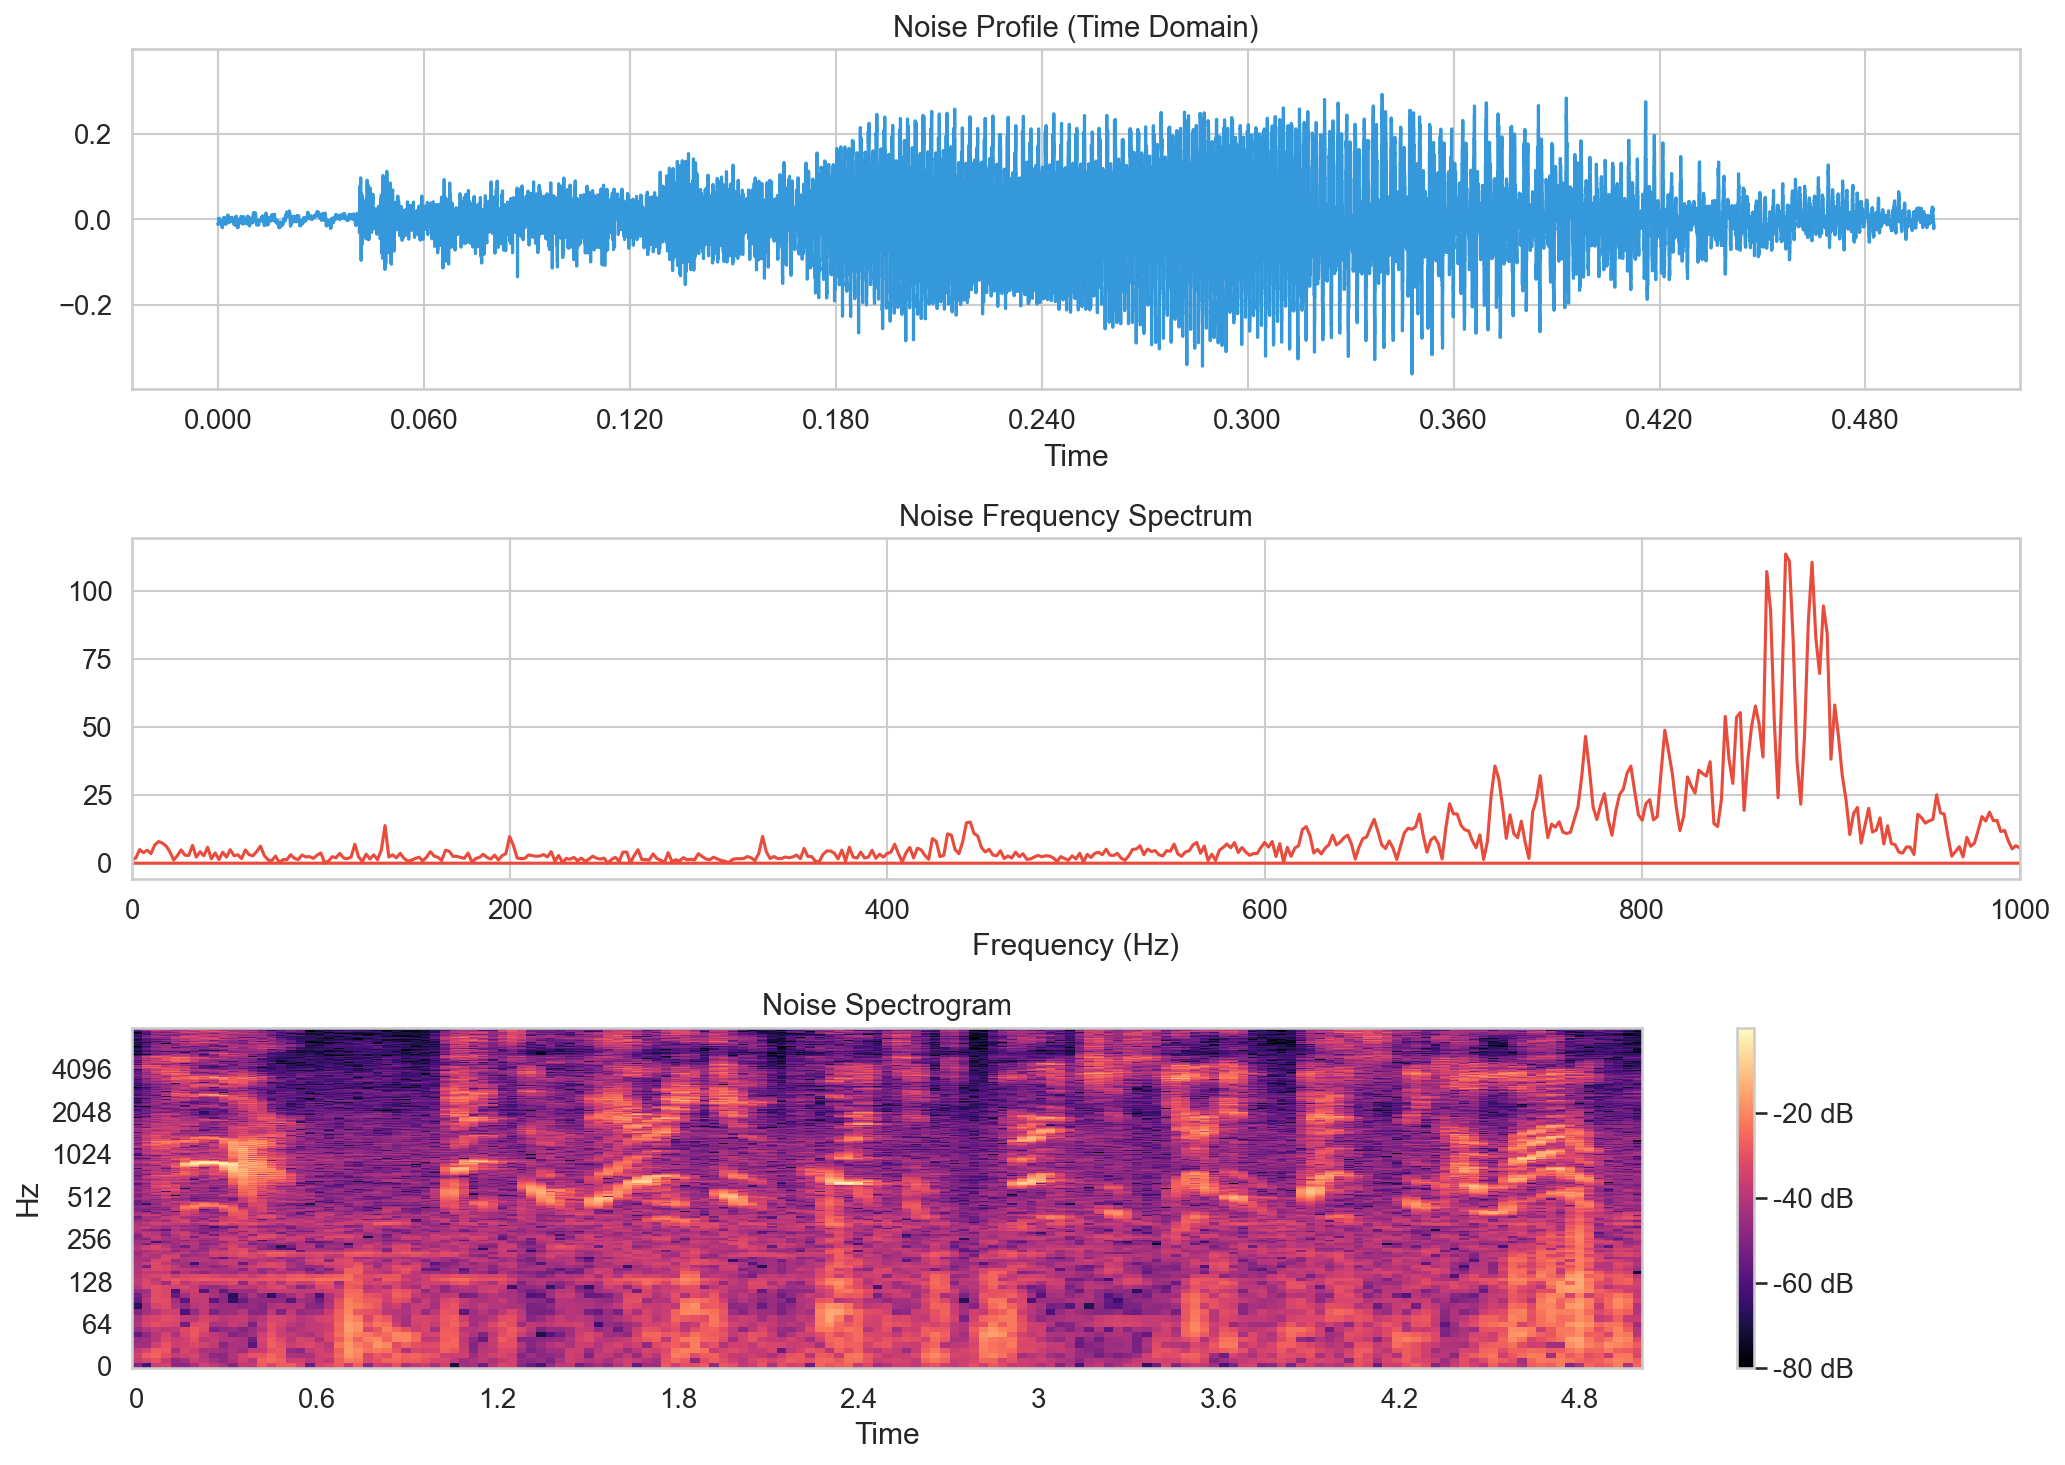

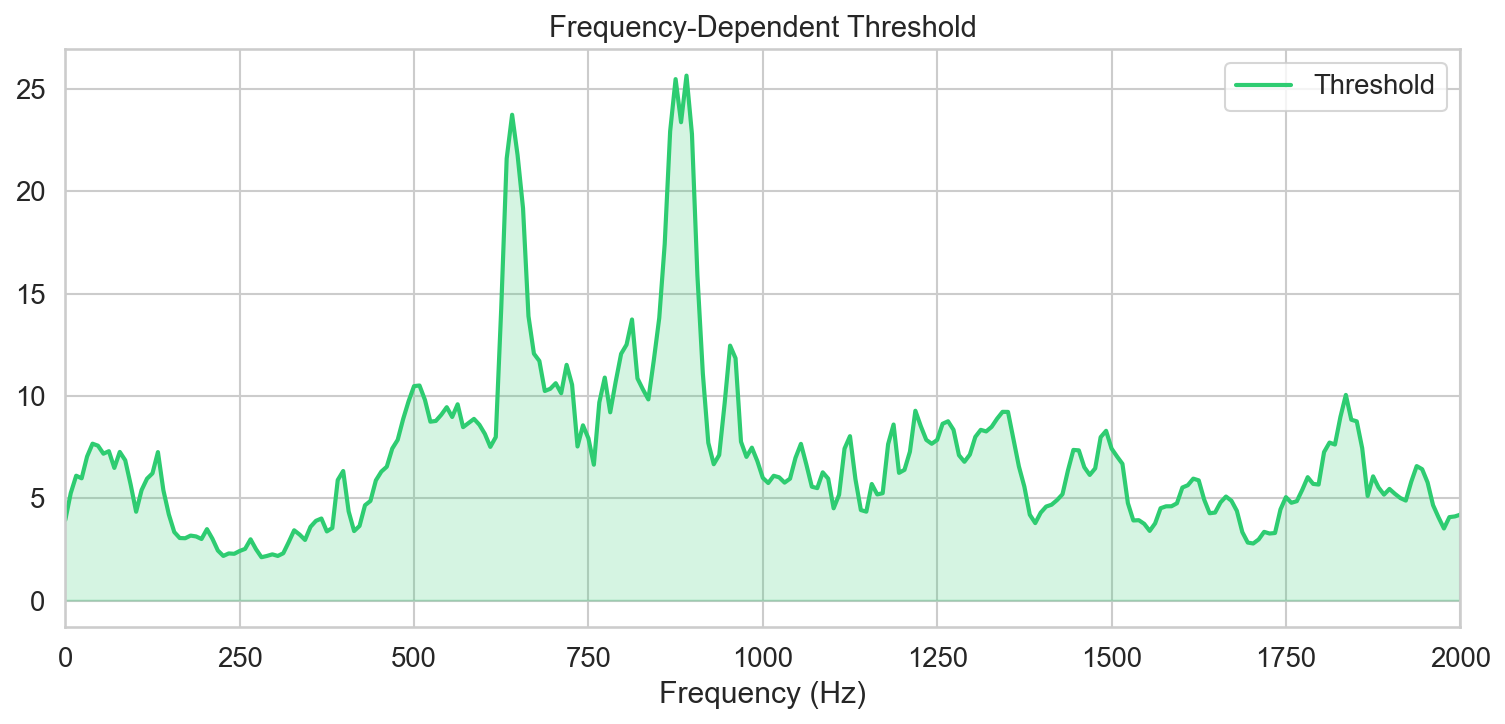

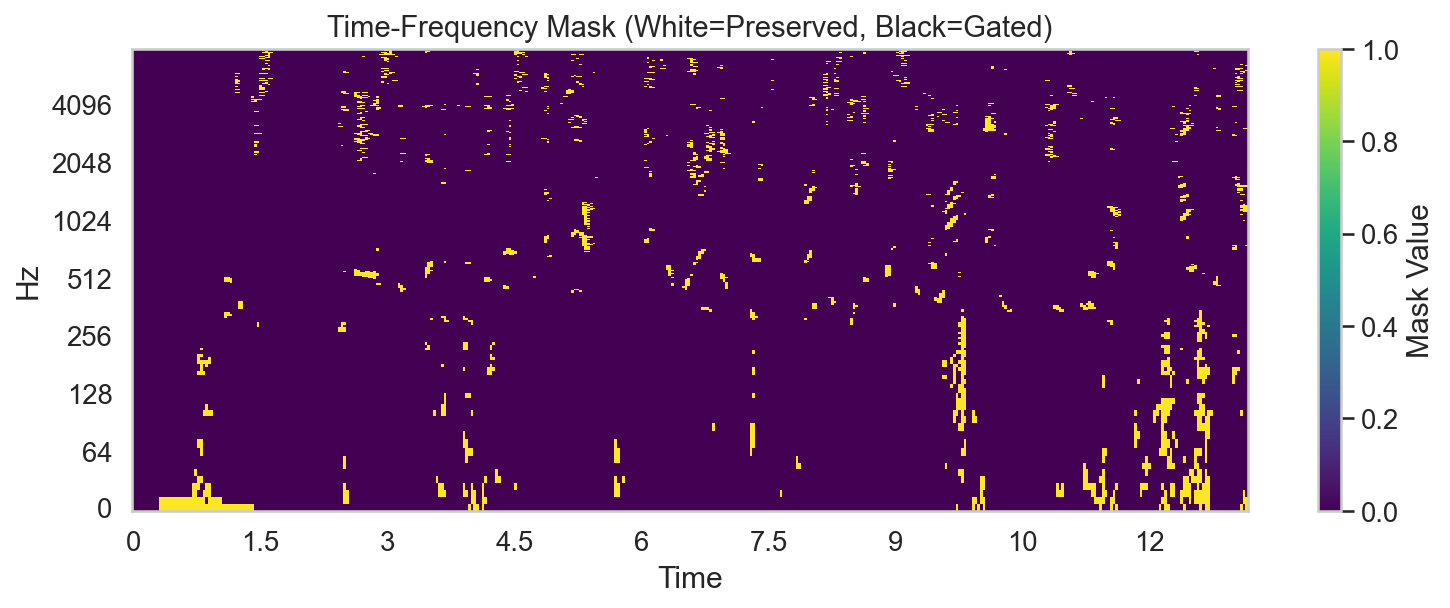

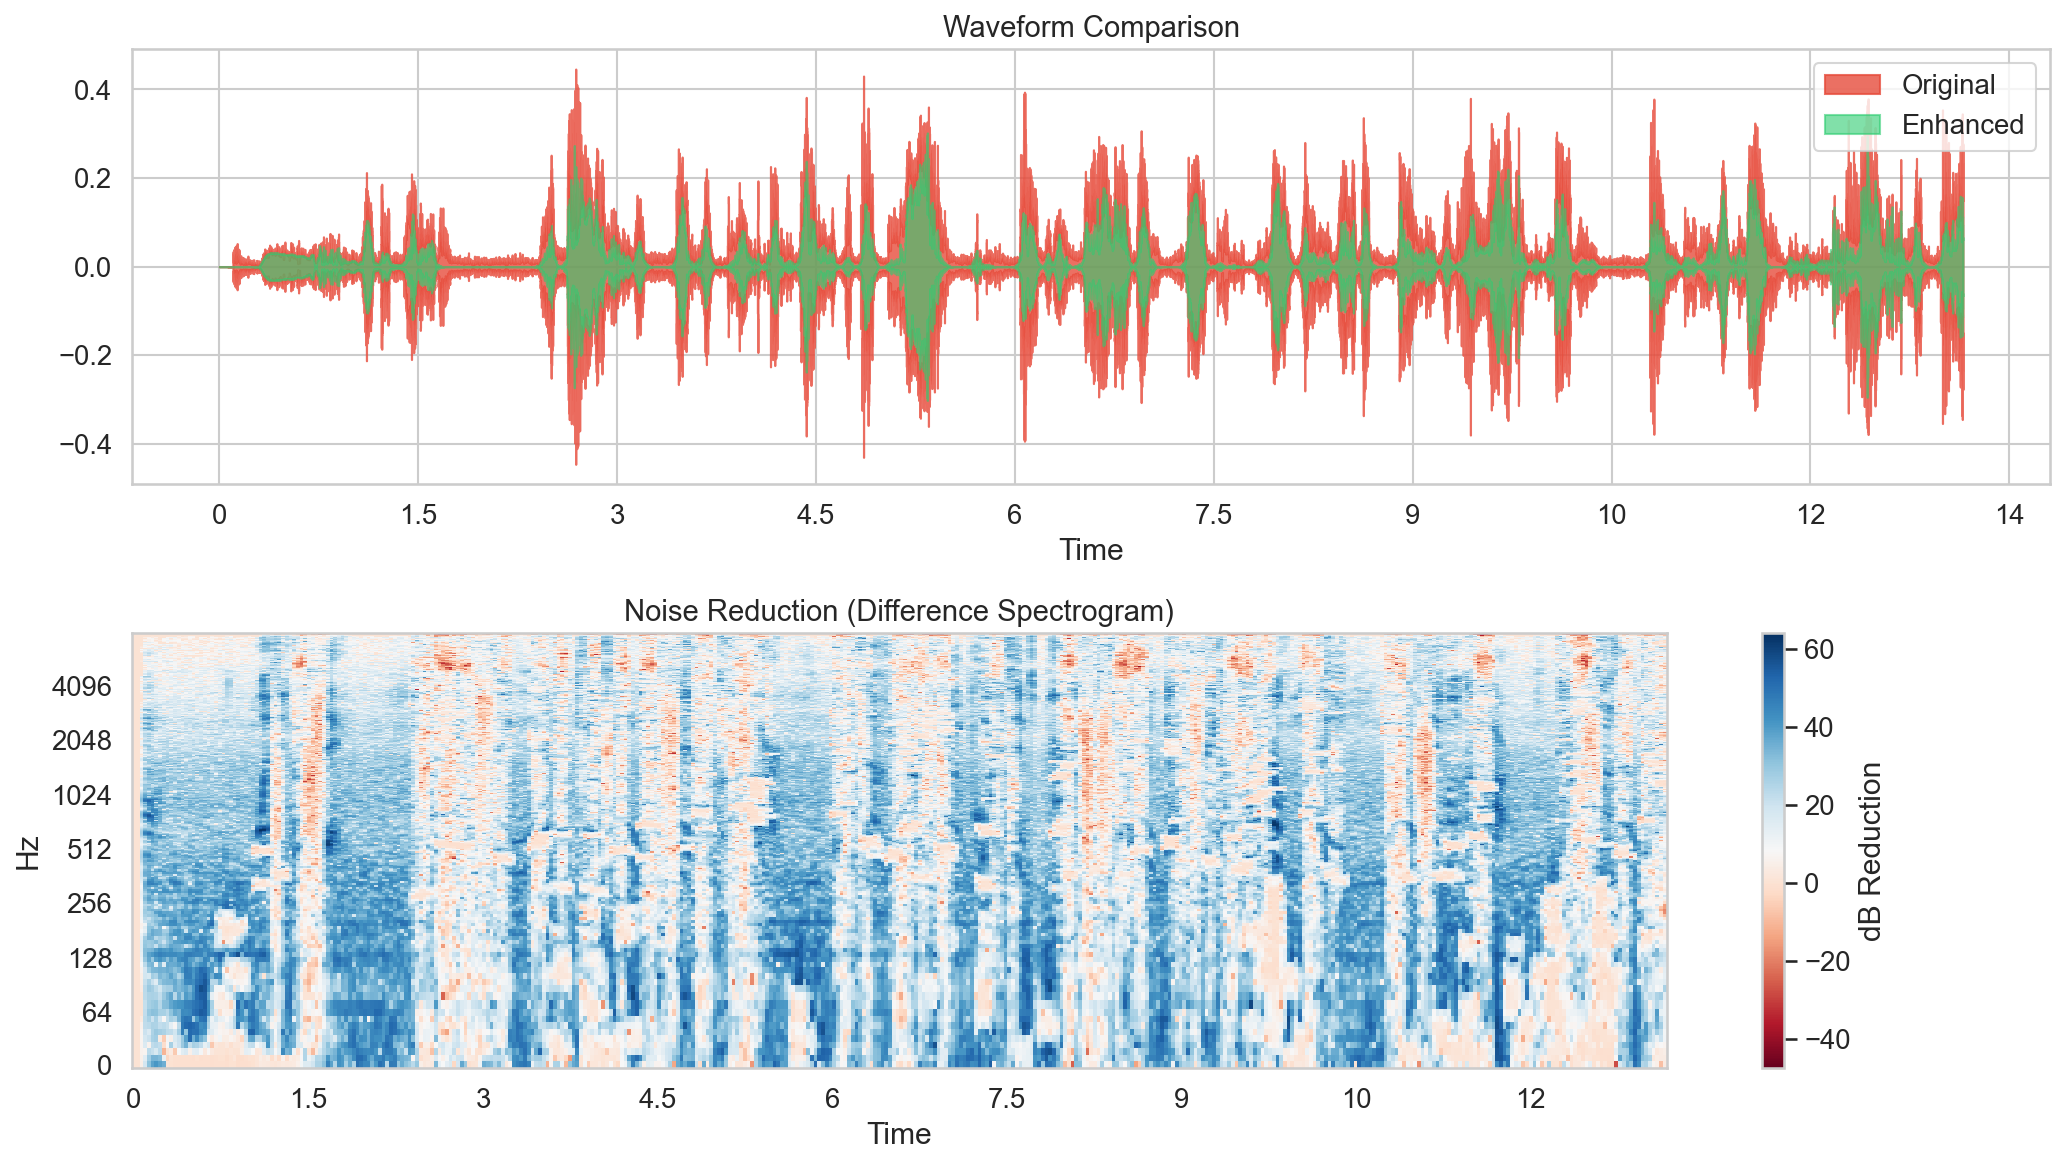

Original Audio:


Enhanced Audio:


In [2]:
import librosa 
import librosa.display 
import matplotlib.pyplot as plt 
import numpy as np 
from IPython.display import Audio, display 
import seaborn as sns 
from scipy.signal import medfilt 
import time 
import warnings

# Ignore warnings for clean output
warnings.filterwarnings("ignore")

# Setup 
sns.set(style='whitegrid', font_scale=1.2) 
plt.rcParams['figure.dpi'] = 150 

# Load audio 
file_path = r"C:\Users\PMLS\Desktop\LECTURE RECORDING 1.mp3" 
y, sr = librosa.load(file_path, sr=16000) 

# Extract noise profile (5 to 10 seconds)
noise_sample = y[int(5*sr):int(10*sr)]

# Spectral Gating Function 
def spectral_gate(y, sr, noise_sample, n_std=3.0, frame_length=2048, hop_length=512): 
    # STFT calculations 
    stft_noise = librosa.stft(noise_sample, n_fft=frame_length, hop_length=hop_length) 
    stft_signal = librosa.stft(y, n_fft=frame_length, hop_length=hop_length) 
    
    # Threshold estimation 
    noise_mag = np.abs(stft_noise) 
    threshold = np.mean(noise_mag, axis=1) + n_std * np.std(noise_mag, axis=1) 
    
    # Create binary mask 
    mask = (np.abs(stft_signal) > threshold[:, np.newaxis]).astype(float) 
    masked_stft = stft_signal * mask 
    
    # Reconstruct audio
    y_clean = librosa.istft(masked_stft, hop_length=hop_length) 
    y_clean = medfilt(y_clean, kernel_size=3) 
    return y_clean, mask, threshold, noise_mag

# Process audio 
y_clean, mask, threshold, noise_mag = spectral_gate(y, sr, noise_sample)

# -------------------------------------------------
# Enhanced Visualizations
# -------------------------------------------------

# 1. Noise Profile Analysis 
plt.figure(figsize=(14, 10)) 

# Noise waveform 
plt.subplot(3, 1, 1) 
librosa.display.waveshow(noise_sample[:int(0.5*sr)], sr=sr, color='#3498db')  
plt.title("Noise Profile (Time Domain)", fontsize=14) 

# Noise spectrum 
plt.subplot(3, 1, 2) 
noise_fft = np.abs(np.fft.fft(noise_sample[:int(0.5*sr)]))[:sr//2] 
freqs = np.fft.fftfreq(len(noise_sample[:int(0.5*sr)]), 1/sr)[:sr//2] 
plt.plot(freqs, noise_fft, color='#e74c3c') 
plt.title("Noise Frequency Spectrum", fontsize=14) 
plt.xlabel("Frequency (Hz)") 
plt.xlim(0, 1000) 

# Noise spectrogram 
plt.subplot(3, 1, 3) 
D_noise = librosa.amplitude_to_db(np.abs(librosa.stft(noise_sample)), ref=np.max) 
librosa.display.specshow(D_noise, sr=sr, x_axis='time', y_axis='log', cmap='magma') 
plt.title("Noise Spectrogram", fontsize=14) 
plt.colorbar(format='%+2.0f dB') 

plt.tight_layout() 
plt.savefig('noise_analysis.png', bbox_inches='tight') 
plt.show()

# 2. Threshold Visualization 
freq_bins = librosa.fft_frequencies(sr=sr, n_fft=2048) 
plt.figure(figsize=(12, 5)) 
plt.plot(freq_bins, threshold, color='#2ecc71', linewidth=2, label='Threshold') 
plt.fill_between(freq_bins, 0, threshold, alpha=0.2, color='#2ecc71') 
plt.title("Frequency-Dependent Threshold", fontsize=14) 
plt.xlabel("Frequency (Hz)") 
plt.xlim(0, 2000) 
plt.legend() 
plt.grid(True) 
plt.savefig('threshold_plot.png', bbox_inches='tight') 
plt.show()

# 3. Binary Mask 
plt.figure(figsize=(12, 4)) 
librosa.display.specshow(mask, sr=sr, x_axis='time', y_axis='log', cmap='viridis') 
plt.title("Time-Frequency Mask (White=Preserved, Black=Gated)", fontsize=14) 
plt.colorbar(label='Mask Value') 
plt.savefig('time_frequency_mask.png', bbox_inches='tight') 
plt.show()

# 4. Original vs Enhanced Comparison 
plt.figure(figsize=(14, 8)) 

plt.subplot(2, 1, 1) 
librosa.display.waveshow(y, sr=sr, color='#e74c3c', alpha=0.8, label='Original') 
librosa.display.waveshow(y_clean, sr=sr, color='#2ecc71', alpha=0.6, label='Enhanced') 
plt.title("Waveform Comparison", fontsize=14) 
plt.legend() 

plt.subplot(2, 1, 2) 
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 
D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(y_clean)), ref=np.max) 
librosa.display.specshow(D - D_clean, sr=sr, x_axis='time', y_axis='log', cmap='RdBu') 
plt.title("Noise Reduction (Difference Spectrogram)", fontsize=14) 
plt.colorbar(label='dB Reduction') 

plt.tight_layout() 
plt.savefig('enhancement_results.png', bbox_inches='tight') 
plt.show()

# Play audio 
print("Original Audio:") 
display(Audio(y, rate=sr)) 
print("Enhanced Audio:") 
display(Audio(y_clean, rate=sr))
